In [1]:
import dp4gp_datasets as datasets
import dp4gp
import GPy

import pandas as pd
import dp4gp_datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import dp4gp


warning in stationary: failed to import cython module: falling back to numpy


# Citibike Demo

In [ ]:
df = datasets.load_citibike(station=None)

In [ ]:
from datetime import datetime
d = datetime.strptime(df.starttime[0],'%m/%d/%Y %H:%M:%S')

In [ ]:
df = df.sample(10000)
datasets.add_citibike_extra_columns(df)

In [ ]:
df.head()

In [ ]:

means = []
stes = []
years = range(1960,2010)
for by in years:
    yeardf = df.loc[df['birth year']==by]
    dist = 60*np.sqrt((yeardf['start station latitude']-yeardf['end station latitude'])**2 + (yeardf['start station longitude']-yeardf['end station longitude'])**2)
    a = dist/(yeardf['tripduration']/3600)    
    means.append(np.mean(a))
    stes.append(np.std(a)/np.sqrt(len(a)))

In [ ]:
means = np.array(means)
stes = np.array(stes)
plt.plot(years,means)
plt.plot(years,means-stes*1.96)
plt.plot(years,means+stes*1.96)
plt.ylim([5,6])

In [ ]:
df.shape

In [ ]:
boundarylist = [('hours',0,24*1,0.5), ('tripduration_mins',0,60.0,20.0)]
output,point_row_form,area_row_form,output_row_form,bins = dp4gp.bin_dataframe(df,boundarylist,verbose=True)

#output_row_form -= np.mean(output_row_form)
#output_row_form /= np.std(output_row_form)
kernel = GPy.kern.Multidimensional_Integral_Limits(input_dim=area_row_form.shape[1],lengthscale=[10.0,1.0],variances=[1.0])
m_int = GPy.models.GPRegression(1.0*area_row_form,1.0*output_row_form[:,None],kernel)
m_int.optimize(messages=True,max_iters=50)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
y = []
x = []
for h in np.arange(0,48,0.1):
    x.append(h)
    res,cov = m_int.predict_noiseless(np.array([[h+0.1,h,0.1,0.0]]))
    y.append(res[0][0])
plt.plot(x,np.array(y)*10) #x10 because step size during training was 0.5 x 20 = 10
plt.plot(area_row_form[area_row_form[:,2]==20,0]-1,output_row_form[area_row_form[:,2]==20])

### GP for DP version

In [ ]:
pseudo_inputs = sparse
lengthscales = 4000.0
sigma = np.ones_like(ys) * sens * 0.1
test_inputs = training_inputs
test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo = dp4gp.get_noise_scale(ys,test_inputs,training_inputs,pseudo_inputs,lengthscales,sigma,calc_normal=True)

# House price example

In [87]:
complete = datasets.load_prices_and_postcode()

In [88]:
ys = complete['price'].values
training_inputs = np.vstack([complete['easting'].values,complete['northing'].values]).T

In [89]:
#squash data into £200k-£700k range
ys[ys>10e5] = 10e5
ys[ys<1e5] = 1e5
sens = 20e5-1e5
#London
#london_east = 530000
#london_north = 180000

#Most of England
london_east = 430000
london_north = 250000
size = 250000

#samp = (training_inputs[:,0]>london_east-size) & (training_inputs[:,0]<london_east+size) & (training_inputs[:,1]>london_north-size) & (training_inputs[:,1]<london_north+size)
#ys = ys[samp]
#training_inputs = training_inputs[samp,:]

#reduce training size if too big
import random
samp = random.sample(range(1, len(ys)), 1000)
ys = ys[samp]

training_inputs = training_inputs[samp,:]

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=17).fit(training_inputs) #50 cities, so using about 70 inducing inputs. just london - use 10

centres = kmeans.cluster_centers_
sparse = []
for i, c in enumerate(centres):
    skip = False
    for d in centres[0:i]:
        if (np.sum((d-c)**2)<5000**2):
            skip = True
            break
    if not skip:
        sparse.append(c)
sparse = np.array(sparse)

In [ ]:
test_inputs = []
step = size/15
for easting in np.arange(london_east-size,london_east+size,step):
    for northing in np.arange(london_north-size,london_north+size,step):
        test_inputs.append([easting,northing])
    
test_inputs = np.array(test_inputs)

In [ ]:
pseudo_inputs = sparse
lengthscales = 50000.0
sigma = np.ones_like(ys) * sens * 0.2
#test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo = dp4gp.get_noise_scale(ys,test_inputs,training_inputs,pseudo_inputs,lengthscales,sigma,calc_normal=True)
test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo = dp4gp.get_noise_scale(ys,test_inputs,training_inputs,pseudo_inputs,lengthscales,sigma,calc_normal=False)

In [ ]:
if normal_msense is not None: 
    print normal_msense
print pseudo_msense
if normal_peroutput_msense is not None: 
    print np.max(normal_peroutput_msense)
print np.max(pseudo_peroutput_msense)

if normal_peroutput_msense is not None: 
    plt.plot(normal_peroutput_msense,'g--')
plt.plot(pseudo_peroutput_msense,'k-')
plt.plot([0,150],[pseudo_msense,pseudo_msense],'k-')
#if normal_msense is not None: 
    #plt.plot([0,150],[normal_msense,normal_msense],'g--')

In [ ]:
#msense = normal_peroutput_msense
msense = pseudo_peroutput_msense
preds = dp4gp.draw_sample(test_cov, test_inputs, pseudo_mu, msense, sens=sens, delta=0.01, eps=5.0)
noise_scale = pseudo_peroutput_msense/np.max(pseudo_peroutput_msense)
#noise_scale = normal_peroutput_msense/np.max(normal_peroutput_msense)        

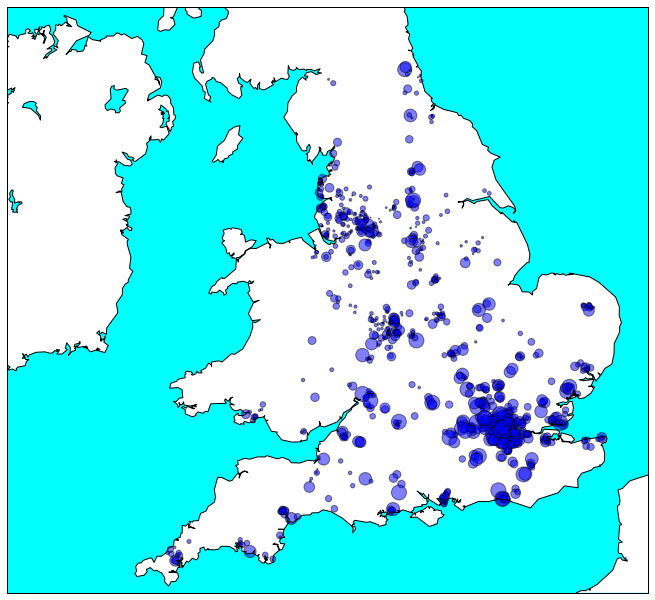

In [90]:
from mpl_toolkits.basemap import Basemap
import mpl_toolkits.basemap.pyproj as pyproj
import matplotlib.pyplot as plt
%matplotlib inline

osgb36=pyproj.Proj("+init=EPSG:27700") # UK Ordnance Survey, 1936 datum
lats,longs = osgb36(training_inputs[:,0],training_inputs[:,1],inverse=True)

m = Basemap(llcrnrlon=-7.6,llcrnrlat=49.8,urcrnrlon=2.5,urcrnrlat=55.5,
            resolution='i',projection='tmerc',lon_0=-2,lat_0=49)#,suppress_ticks=False)

m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='white',lake_color='aqua',zorder=0)
#m.drawrivers()
#m.drawcounties()

#for x,y in zip(xs,ys):
#    plt.plot(x,y,'x')

m.scatter(lats,longs,(ys-np.min(ys))/1000,latlon=True,marker='.',alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
plt.figure(figsize=(20,20))
for x,y,p in zip(training_inputs[:,0],training_inputs[:,1],(np.sqrt(ys)-np.sqrt(np.min(ys)))/50):
    plt.plot(x,y,'o',color='orange',markersize=p,alpha=1)
    
plt.axis('equal')
ax = plt.gca()
ax.set_axis_bgcolor('black')

plt.plot(sparse[:,0],sparse[:,1],'bx',markersize=10,alpha=1.0,markeredgewidth=5)
plt.xlim([london_east-size,london_east+size])
plt.ylim([london_north-size,london_north+size])

for x,y,p,noise in zip(test_inputs[:,0],test_inputs[:,1],(np.sqrt(preds)-np.sqrt(np.min(preds)))/20,noise_scale):
    if noise>0.5:
        plt.plot(x,y,'wx',markersize=10,alpha=1)
    else:
        plt.plot(x,y,'wo',markersize=p,alpha=1)#-noise)

### Numerical comparison

Sample at each training point (not we don't leave one out, we are leaving in the training data)

In [ ]:
pseudo_inputs = sparse
test_inputs = training_inputs[0:1000,:]
#lengthscales = 2000.0
calc_normal = False
test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo = dp4gp.get_noise_scale(ys,test_inputs,training_inputs,pseudo_inputs,lengthscales,sigma,calc_normal=calc_normal)

Draw a sample...

In [ ]:
#preds = dp4gp.draw_sample(test_cov, test_inputs, normal_mu, normal_peroutput_msense, sens=sens, delta=0.01, eps=5.0)
preds = dp4gp.draw_sample(test_cov, test_inputs, pseudo_mu, pseudo_peroutput_msense, sens=sens, delta=0.01, eps=3.0)

In [ ]:
plt.plot(ys[0:1000],preds,'x')
plt.xlim([0,0.8e6])
plt.ylim([0,0.8e6])

#### Slice through the country...

In [ ]:
sliceNorthing = 200000
sliceWidth = 2000
inSlice = (complete['northing']>sliceNorthing-sliceWidth) & (complete['northing']<sliceNorthing+sliceWidth)
housesInSlice = complete[inSlice]
#for e,n,p in zip(housesInSlice['easting'],housesInSlice['northing'],housesInSlice['price']):
#    plt.plot(e,n,'ok',markersize=p/1e5,alpha=0.4)

plt.plot(housesInSlice['easting'],np.log(housesInSlice['price']),'o',alpha=0.34)


In [ ]:
plt.figure(figsize=(20,10))
plt.plot(complete['northing'],complete['price'],'ko',markersize=1,alpha=0.05)
plt.ylim([0,1e6])


In [ ]:
for e,n,p in zip(complete['easting'],complete['northing'],complete['price']):
    plt.plot(e,n,'ok',markersize=p/1e5,alpha=0.4)

In [ ]:
len(complete)